# Job Classifier Notebook Using NLP and ML

This notebook uses natural language processing and machine learning to classify IAM jobs based on the job description text.

## 1. Install and load packages

In [7]:
#pip install numpy pandas sklearn wordcloud textblob

In [8]:
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from nltk import ngrams
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from sklearn import linear_model, naive_bayes, svm
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


## 2. Load data into a dataframe

In [9]:
df = pd.read_csv("../project_data/data-jobs-20221123.csv", encoding = "utf-8")
df.head()

,job_title,role,description
0,"Business Intelligence Engineer, Identity and A...",engineer,· 3+ years in relevant experience as Business ...
1,Data Integration Developer,developer,· Using API connections and flat files ingests...
2,Identity and Access Management (IDAM) Operatio...,analyst,** NO Corp-to-Corp**\n\n\nMust be local or wil...
3,Identity and Access Management Engineer - IAM ...,engineer,**REMOTE OPPORTUNITY**\r\n\r\nEmBark is curren...
4,ServiceNow Developer (All Levels Remote),developer,*We are open to supporting 100% remote work an...


## 3. Tokenize and clean job description

In [10]:
tokenizer = RegexpTokenizer(r'\w+')
stop_words = stopwords.words('english')

other_stop_words = ['introduction', 'searching', 'opportunity', 'play','working','without','preferred', 'people', 'well','veteran', 'status','dramatic', 'growth', 'highly']

stop_words.extend(other_stop_words)

#lowercase
df["desc_1"] = df.description.str.lower()
#remove \n
df["desc_2"] = df.desc_1.str.replace("\n", " ")
#remove punctuation and tokenize
df["Tokens"] = df.apply(lambda row: tokenizer.tokenize(row['desc_2']), axis=1)
#remove stopwords
df['Tokens_1'] = df['Tokens'].apply(lambda x: [item for item in x if item not in stop_words])
#merge tokens back into string text
df['desc_3']=[" ".join(txt) for txt in df["Tokens_1"].values]
#create bigrams
df["Tokens_2"] = df["Tokens_1"].apply(lambda row: list(ngrams(row, 2)))
df.head()

,job_title,role,description,desc_1,desc_2,Tokens,Tokens_1,desc_3,Tokens_2
0,"Business Intelligence Engineer, Identity and A...",engineer,· 3+ years in relevant experience as Business ...,· 3+ years in relevant experience as business ...,· 3+ years in relevant experience as business ...,"[3, years, in, relevant, experience, as, busin...","[3, years, relevant, experience, business, int...",3 years relevant experience business intellige...,"[(3, years), (years, relevant), (relevant, exp..."
1,Data Integration Developer,developer,· Using API connections and flat files ingests...,· using api connections and flat files ingests...,· using api connections and flat files ingests...,"[using, api, connections, and, flat, files, in...","[using, api, connections, flat, files, ingests...",using api connections flat files ingests parse...,"[(using, api), (api, connections), (connection..."
2,Identity and Access Management (IDAM) Operatio...,analyst,** NO Corp-to-Corp**\n\n\nMust be local or wil...,** no corp-to-corp**\n\n\nmust be local or wil...,** no corp-to-corp** must be local or willin...,"[no, corp, to, corp, must, be, local, or, will...","[corp, corp, must, local, willing, relocate, e...",corp corp must local willing relocate expense ...,"[(corp, corp), (corp, must), (must, local), (l..."
3,Identity and Access Management Engineer - IAM ...,engineer,**REMOTE OPPORTUNITY**\r\n\r\nEmBark is curren...,**remote opportunity**\r\n\r\nembark is curren...,**remote opportunity**\r \r embark is currentl...,"[remote, opportunity, embark, is, currently, s...","[remote, embark, currently, seeking, experienc...",remote embark currently seeking experienced ia...,"[(remote, embark), (embark, currently), (curre..."
4,ServiceNow Developer (All Levels Remote),developer,*We are open to supporting 100% remote work an...,*we are open to supporting 100% remote work an...,*we are open to supporting 100% remote work an...,"[we, are, open, to, supporting, 100, remote, w...","[open, supporting, 100, remote, work, anywhere...",open supporting 100 remote work anywhere withi...,"[(open, supporting), (supporting, 100), (100, ..."


## 4. Generate Labels (label)

In [11]:
encoder = LabelEncoder()
label = encoder.fit_transform(df.role)
print(label)

[4 3 1 4 3 4 4 4 6 4 5 4 5 3 5 4 1 4 4 5 4 3 1 1 4 4 5 1 7 1 0 3 3 3 4 5 1
 5 1 3 3 5 5 1 1 5 4 6 4 1 6 4 6 1 4 6 5 1 4 1 4 4 1 4 1 4 3 4 4 2 4 4 4 6
 6 6 5 5 4 1 5 2 4 5 2 4 1 4 1 5 2 1 1 5 1 5 4 4 7 4 4 2 3 3 6 5 4 2 6 1 1
 3 1 6 3 0 1 4 5 1 4 5 4 5 4 6 5 1 1 1 5 4 2 1 2 5 4 1 6 5 6 4 4 4 1 2 1 6
 6 7 6 4 5 5 6 4 4 0 4 1 5 6 6 5 7 4 4 5 2 2 4 1 4 5 1 2 4 4 5 1 4 6 0 4 3
 1 4 5 1 5 0 6 3 4 0 6 1 6 3 4 3 3 6 6 6 1 1 2 4 6 4 5 6 4 1 5 4 1 4 3 5 4
 1 4 1 4 7 0 5 4 3 4 4 0 3 4 7 0 3 4 4 4 5 1 3 4 4 3 2 6 4 4 5 4 4 5 6 4 6
 6 0 6 6 4 1 0 6 4 4 1 1 0 1 4 5 5 4 6 2 1 3 5 4 6 5 6 4 5 5 1 3 4 4 1 1 3
 6 4 4 2 1 5 3 4 7 4 4 1 1 4 4 4 4 1 4 4 6 4 4 2 7 4 0 4 4 6 6 1 3 3 4 4 5
 1 1 4 4 6 1 4 4 6 2 5 7 4 3 0 1 0 1 1 4 4 7 7 3 3 4 4 5 5 6 4 5 3 0 7 4 1
 4 2 0 2 3 1 4 1 4 6 6 4 7 0 5 4 5 6 1 4 6 6 4 1 1 1 4 1 7 3 5 5 3 1 4 6 4
 4 3 3 0 4 1 1 1 6 3 4 4 6 4 6 5 4 3 4 6 4 4 4 4 1 1 4 6 6 1 4 1 4 1 1 1 1
 5 5 5 5 4 1 4 6]


## 5. Transform job description text into term frequency–inverse document frequency (TDIDF) format and make ML model with accuracy score

Determine the classifer accuracy based on the max words.

In [12]:
v = TfidfVectorizer(max_features=200, min_df=.2, max_df=.7)

x = df["desc_3"]

v.fit(x)

x_tfidf = v.transform(x)

#print(x_tfidf)

#use to see high frequency words
#print(v2.get(99))

#print(v.vocabulary_)

# Classifier - Algorithm - SVM
s = svm.LinearSVC(C=1.0)

# fit the training dataset on the classifier
s.fit(x_tfidf, label)# predict the labels on validation dataset

# make predictions using the trained model
s_pred = s.predict(x_tfidf)

# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(s_pred, label)*100)


SVM Accuracy Score ->  92.2566371681416


## 7. Identify model gaps using confusion matrix

Confusion matrix, without normalization


array(['administrator', 'analyst', 'architect', 'developer', 'engineer',
       'leadership', 'manager', 'specialist'], dtype=object)

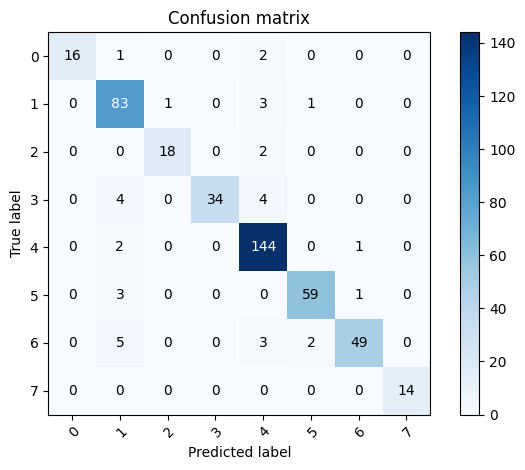

In [13]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

class_names = np.unique(label)

plot_confusion_matrix(label, s_pred, classes=class_names, title='Confusion matrix')

np.unique(df.role)

## 8. Plot roles

/Users/kenmye/Library/Python/3.8/lib/python/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/kenmye/Library/Python/3.8/lib/python/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


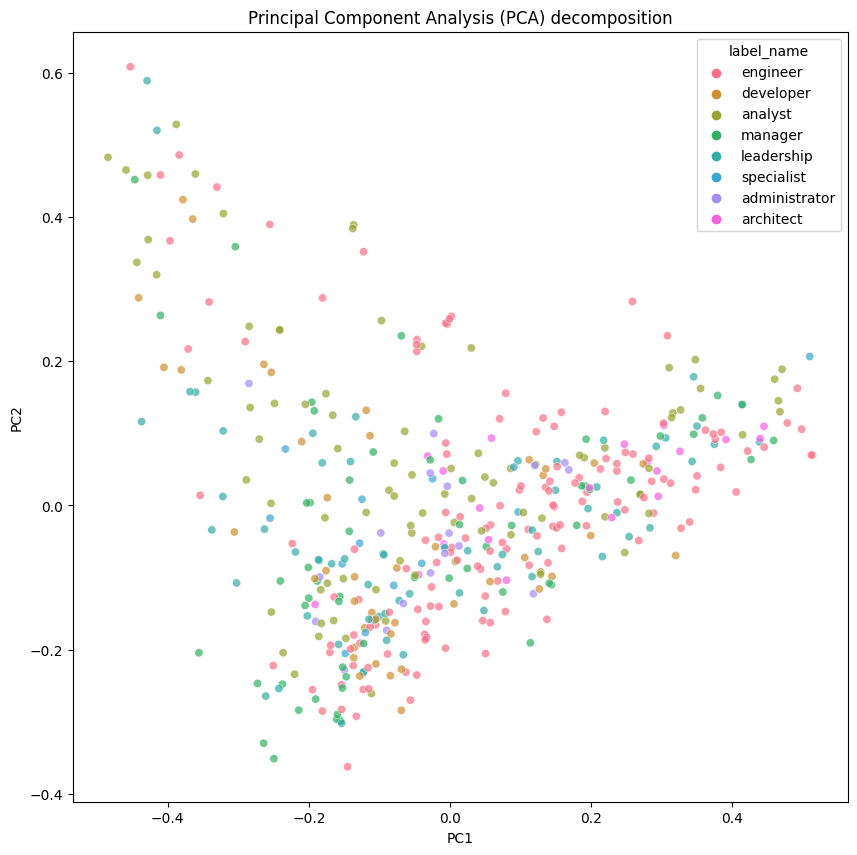

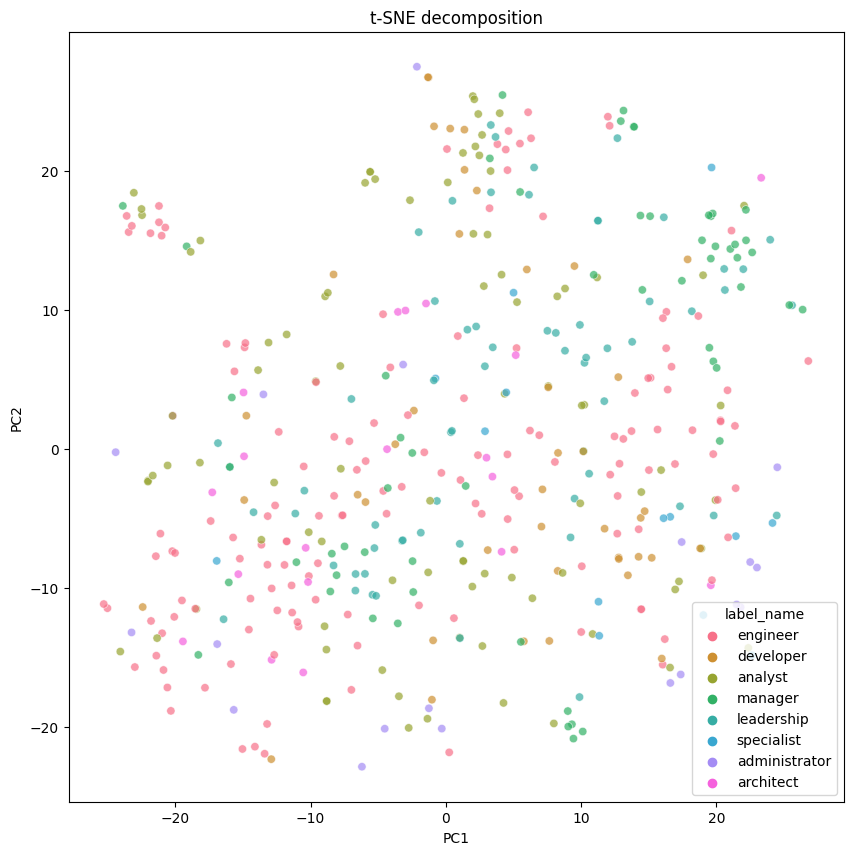

In [14]:
def plot_dim_red(model, features, labels, n_components=2):
    
    # Creation of the model
    if (model == 'PCA'):
        mod = PCA(n_components=n_components)
        title = "Principal Component Analysis (PCA) decomposition"  # for the plot
        
    elif (model == 'TSNE'):
        mod = TSNE(n_components=2)
        title = "t-SNE decomposition" 

    else:
        return "Error"
    
    # Fit and transform the features
    principal_components = mod.fit_transform(features)
    
    # Put them into a dataframe
    df_features = pd.DataFrame(data=principal_components,
                     columns=['PC1', 'PC2'])
    
    # Now we have to paste each row's label and its meaning
    # Convert labels array to df
    df_labels = pd.DataFrame(data=labels,
                             columns=['label'])
    
    df_full = pd.concat([df_features, df_labels], axis=1)
    df_full['label'] = df_full['label'].astype(str)

    # Get labels name
    category_names = {
        "0": 'administrator',
        "1": 'analyst',
        "2": 'architect',
        "3": 'developer',
        "4": 'engineer',
        "5": 'leadership',
        "6": 'manager',
        "7": 'specialist'
    }

    # And map labels
    df_full['label_name'] = df_full['label']
    df_full = df_full.replace({'label_name':category_names})

    # Plot
    plt.figure(figsize=(10,10))
    sns.set_palette("hls", 5)
    sns.scatterplot(x='PC1',
                    y='PC2',
                    hue="label_name", 
                    data=df_full,
                    #palette=["red", "orange", "darkgreen", "blue", "purple"],
                    alpha=.7).set_title(title);

plot_dim_red("PCA", features=x_tfidf.toarray(), labels=label, n_components=2)

plot_dim_red("TSNE", features=x_tfidf.toarray(), labels=label, n_components=2)

df["SVM_Prediction"] = s_pred

#from pathlib import Path  
#filepath = Path('out.csv')  
#df.to_csv(filepath) 

In [17]:
df.head()
df.to_csv('../project_data/3-processed-classify-jobs.csv')